### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Fall 2018 ###

# Project Supplement - TSP Algorithm Comparison #

#### Kartik Sreenivasan (email address), Matthew Crepea (email address), Talha Sultan (email address), and Eric Brandt (elbrandt@wisc.edu)

This document compares performance of 4 implementations of a TSP solver and was used in preparation for our main project, [Automotive Inspection with the Laser Radar](Automotive Inspection with the Laser Radar.ipynb)

We separately evaluated that each formulation gives the same answer. This document simply compares performance.

Four different TSP algorithms are evaluated using a pre-defined cost matrix:
1. MTZ formulation (from class lecture)
2. Iterative Subtour Elimination (from class lecture)
3. Subtour Elmination using Lazy Constraints (based on 2, but using additional JuMP/Gurobi capability of `@lazyconstraint`)
4. Symmetric Matrix & Lazy Subtour Elimination (based on Gurobi website [example](http://examples.gurobi.com/traveling-salesman-problem/))

## Results

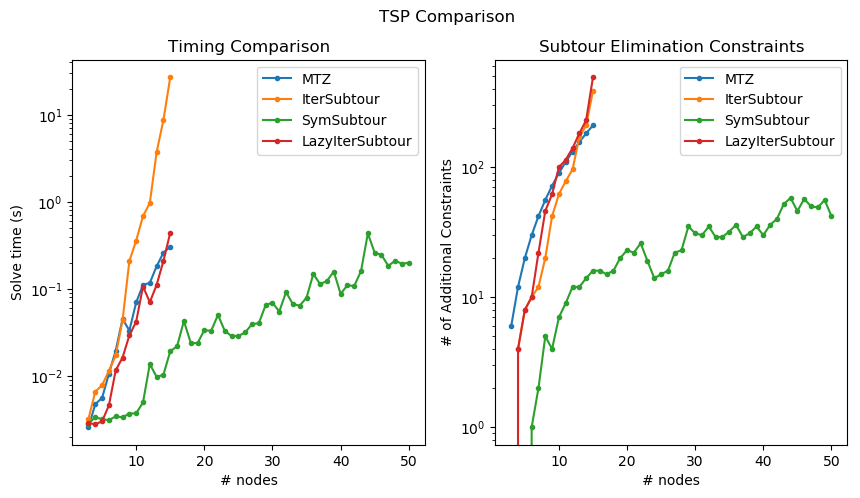

In [60]:
if !isdefined(:algorithms)
    error("You must run all notebook cells below this one first! (run the last one twice, for accurate timing)")
end

# plot timing results
using PyPlot
fig = figure("TSP Comparison", figsize=(10,5))
suptitle("TSP Comparison")
subplot("121")
title("Timing Comparison")
yscale("log")
xlabel("# nodes")
ylabel("Solve time (s)")
for (nm, val) in algorithms
    plot(val[2], val[3], ".-", label=nm)
end
legend();

# plot additional constraint results
subplot("122")
title("Subtour Elimination Constraints")
yscale("log")
xlabel("# nodes")
ylabel("# of Additional Constraints")
for (nm, val) in algorithms
    plot(val[2], val[4], ".-", label=nm)
end
legend();
savefig("TSP_Comparison_Chart.png")


## MTZ Formulation

In [1]:
using JuMP, Gurobi

In [38]:
function TSP_MTZ(cost)
    n = size(cost,1) # number of features

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z[1:n, 1:n], Bin)
    @objective(m, Min, sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,:]) == 1) # leave each feature once
    @constraint(m, [j in 1:n], sum(z[:,j]) == 1) # arrive at each feature once
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self
    
    # MTZ variables and constraints
    @variable(m, u[1:n])
    @constraint(m, [i=1:n, j=2:n], u[i] - u[j] + n*z[i,j] <= n-1 )
        
    solve(m)
    return n * (n - 1) # number of additional constraints added
end;

## Iterative Solve with Subtour Elimination

In [24]:
function find_subtour(idxs,start)
    subtour = [start]
    while true
        next = idxs[subtour[end]]
        push!(subtour,next)
        if start == next
            break
        end
    end
    return subtour
end

function find_subtours(idxs)
    remaining = [i for i=1:length(idxs)]
    subtours = []
    while length(remaining) > 0
        subtour = find_subtour(idxs, remaining[1])
        push!(subtours, subtour)
        remaining = setdiff(remaining, subtour)
    end
    return subtours
end

function TSP_IterSubtour(cost)
    n = size(cost,1) # number of features

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z[1:n, 1:n], Bin)
    @objective(m, Min, sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,:]) == 1) # leave each feature once
    @constraint(m, [j in 1:n], sum(z[:,j]) == 1) # arrive at each feature once
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self
    
    iter = 0
    solved = false
    num_additional_constraints = 0
    while iter < 100 && !solved
        iter += 1
        
        #solve
        t1 = @timed(solve(m))
        soln = getvalue(z)

        # check for subtours
        idxs = [find(soln[i,:] .>= 0.9)[1] for i=1:n]
        subtours = find_subtours(idxs)
        if length(subtours) == 1
            solved = true;
        else
            # add constraints to prohibit these subtours
            for subtour in subtours
                len = length(subtour)
                # prohibit these particular features from being a tour
                @constraint(m, sum( z[subtour[i],subtour[i+1]] for i = 1:len-1 ) <= len-2)
                # and prohibit the reverse
                @constraint(m, sum( z[subtour[i+1],subtour[i]] for i = 1:len-1 ) <= len-2)
                num_additional_constraints += 2
            end            
        end        
    end
    return num_additional_constraints
end;

## Lazy Iterative Subtour Elimination

In [23]:
function TSP_LazyIterSubtour(cost)
    n = size(cost,1) # number of features

    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, z[1:n, 1:n], Bin)
    @objective(m, Min, sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,:]) == 1) # leave each feature once
    @constraint(m, [j in 1:n], sum(z[:,j]) == 1) # arrive at each feature once
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self
    
    num_additional_constraints = 0
        
    function subtour_callback(cb)
        soln = getvalue(z)
        # check for subtours
        idxs = [find(soln[i,:] .>= 0.9)[1] for i=1:n]
        subtours = find_subtours(idxs)
        if length(subtours) == 1
            solved = true;
        else
            # add constraints to prohibit these subtours
            for subtour in subtours
                len = length(subtour)
                # prohibit these particular features from being a tour
                @lazyconstraint(cb, sum( z[subtour[i],subtour[i+1]] for i = 1:len-1 ) <= len-2)
                # and prohibit the reverse
                @lazyconstraint(cb, sum( z[subtour[i+1],subtour[i]] for i = 1:len-1 ) <= len-2)
                num_additional_constraints += 2
            end            
        end        
    end
    
    addlazycallback(m, subtour_callback)
    solve(m)
    return num_additional_constraints
end;

## Symmetric Formulation w/ Lazy Subtour Elimination

In [31]:
function sym_find_subtour(edges, n)
    visited = [false for i=1:n]
    cycles=[]
    lengths=[]
    selected=[[] for i=1:n]
    for e in edges
        push!(selected[e[1]], e[2])
    end
    while true
        current = find(visited .== false)[1]
        thiscycle = [current]
        while true
            visited[current] = true
            neighbors = []
            for x in selected[current]
                if visited[x] == false
                    push!(neighbors, x)
                end
            end
            if length(neighbors) == 0
                break
            end
            current = neighbors[1]
            push!(thiscycle, current)
        end
        push!(cycles, thiscycle)
        push!(lengths, length(thiscycle))
        if sum(lengths) == n
            break
        end
    end
    return cycles[indmin(lengths)]
end

function TSP_Sym(cost)
    n = size(cost,1) # number of features

    # TSP solve
    m = Model(solver=GurobiSolver(OutputFlag=0))    
    # use the symmetric matrix formulation & subtour elimination described at
    #  http://examples.gurobi.com/traveling-salesman-problem/
    @variable(m, z[i=1:n, j=1:n], Bin, Symmetric)
    @objective(m, Min, 0.5*sum(z.*cost)) # minimize the sum of movement times
    @constraint(m, [i in 1:n], sum(z[i,j] for j=1:n) == 2 ) # one in and one out edge
    @constraint(m, [ii in 1:n], z[ii,ii] == 0) # can't transition to self

    num_lazy_constraints = 0
    function subtour_callback(cb)
        soln = getvalue(z)
        # check for subtours
        selected = [[i,j] for i=1:n, j=1:n if soln[i,j] > 0.5]
        subtour = sym_find_subtour(selected, n)
        if length(subtour) == n
            return
        end
        # add constraint to prohibit these subtours
        len = length(subtour)
        subtour = sort(subtour)
        num_lazy_constraints += 1
        @lazyconstraint(cb, sum( z[subtour[j],subtour[i]] for i = 1:len, j=i:len ) <= len-1)
    end

    # add the lazy constraint callback and solve
    addlazycallback(m, subtour_callback)
    solve(m)
    return num_lazy_constraints
end;

## Test Harness

In [43]:
cost = readcsv("cost.csv")
sm_set = 3:15
lg_set = 3:50
algorithms = Dict([
        ("MTZ",             [TSP_MTZ, sm_set, [], []])
        ("IterSubtour",     [TSP_IterSubtour, sm_set, [], []])
        ("LazyIterSubtour", [TSP_LazyIterSubtour, sm_set, [], []])
        ("SymSubtour",      [TSP_Sym, lg_set, [], []])
        ])
results = Dict()
for (key, val) in algorithms
    for s in val[2]
        tm = @timed(val[1](cost[1:s,1:s]))
        push!(val[3], tm[2]) # store time of execution
        push!(val[4], tm[1]) # store num additional constraints
    end
end

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice